In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras import layers
import torch
import numpy as np
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
import random 

2024-04-06 16:07:13.872874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 16:07:13.873000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 16:07:14.009244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Data Pipeline**

In [2]:
test_balanced = np.load("../input/balanced-ds/test_balanced.npy",allow_pickle=True)
train_balanced = np.load("../input/balanced-ds/train_balanced.npy",allow_pickle=True)
validate_balanced = np.load("../input/balanced-ds/validate_balanced.npy",allow_pickle=True)

In [3]:
def getLexedArrays(path, size=-1):
    array = []
    with open(path, 'r') as f:
        i = 0
        while size == -1 or i < size:
            line = f.readline()
            if line:
                array.append(line.split())
                i += 1
            else:
                break
    return array


def getLabels(path, size=-1):
    array = []
    with open(path, 'r') as f:
        i = 0
        while size == -1 or i < size:
            line = f.readline()
            if line:
                array.append(int(line))
                i += 1
            else:
                break
    return array

In [4]:
test_arrays = getLexedArrays('../input/lexeds-vdisc/lexed_VDISC/VDISC_test')
train_arrays = getLexedArrays('../input/lexeds-vdisc/lexed_VDISC/VDISC_train')
val_arrays = getLexedArrays('../input/lexeds-vdisc/lexed_VDISC/VDISC_validate')

test_labels = np.array(getLabels('../input/labels-vdisc/labels_VDISC/VDISC_test'))
train_labels = np.array(getLabels('../input/labels-vdisc/labels_VDISC/VDISC_train'))
val_labels = np.array(getLabels('../input/labels-vdisc/labels_VDISC/VDISC_validate'))

In [5]:
ds_sizes = [5000, 30000, 5000]
test_classes, train_classes, val_classes = [[[(test_arrays, train_arrays, val_arrays)[k][j] for j in np.resize(np.array(np.nonzero(labels == i)[0]), ds_sizes[k])] for i in (-1, 1, 2, 3, 4, 5)] for k, labels in enumerate((test_labels, train_labels, val_labels))]

In [30]:
len(val_classes[0])

5000

In [6]:
max_len = 0
for lexed_arrays in (test_arrays, train_arrays, val_arrays):
    for ar in lexed_arrays:
        max_len = max(max_len, len(ar))

#### **Create Tensorflow Datasets from Generator**

In [24]:
VEC_DIM = 15

def data_generator(dataset, labels, label_prob, isLabelled=True):
    w2vmodel = Word2Vec.load("../input/modelll/embedding.model")
    vec_ems = np.zeros((max_len, VEC_DIM))
    for j, ar in enumerate(dataset):
        real_label = None
        
        if isLabelled:
            real_label = labels[j] if labels[j] != -1 else 0
            
        if isLabelled and random.uniform(0, 1) > label_prob[real_label]:
            continue
            
        vec_ems *= 0

        for i, k in enumerate(ar):
            vec = None
            if k not in w2vmodel.wv:
                vec = w2vmodel.wv['<|na|>']
            else:
                vec = w2vmodel.wv[k]
            vec_ems[i, :] = vec
        
        if isLabelled:
            yield (vec_ems, real_label)
        else:
            yield vec_ems

def data_generator2(dataset, isLabelled=True):
    w2vmodel = Word2Vec.load("../input/modelll/embedding.model")
    vec_ems = np.zeros((max_len, VEC_DIM))
    for i in range(len(dataset[0])):
        for j in range(len(dataset)):
            ar = dataset[j][i]
            
            vec_ems *= 0
            for o, k in enumerate(ar):
                vec = None
                if k not in w2vmodel.wv:
                    vec = w2vmodel.wv['<|na|>']
                else:
                    vec = w2vmodel.wv[k]
                vec_ems[o, :] = vec
                
            if isLabelled:
                yield (vec_ems, j)
            else:
                yield vec_ems
    

test_ds = tf.data.Dataset.from_generator(
    lambda: data_generator2(test_classes),
    output_types=(tf.float32, tf.float32), 
    output_shapes=((max_len, VEC_DIM), ()),
)

train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator2(train_classes),
    output_types=(tf.float32, tf.float32), 
    output_shapes=((max_len, VEC_DIM), ()),
)

val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator2(val_classes, False),
    output_types=(tf.float32), 
    output_shapes=(max_len, VEC_DIM),
)

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train_ds = train_ds.repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [8]:
for vec_em, label in train_ds.take(1):
    print(vec_em[:6,:,0])
    print(label)

tf.Tensor(
[[0.69339466 0.2851518  0.9262394  ... 0.         0.         0.        ]
 [0.69339466 0.2851518  0.68744874 ... 0.         0.         0.        ]
 [0.69339466 0.2851518  0.69339466 ... 0.         0.         0.        ]
 [0.69339466 0.2851518  1.7819568  ... 0.         0.         0.        ]
 [0.69339466 0.2851518  0.69339466 ... 0.         0.         0.        ]
 [0.69339466 0.2851518  0.69339466 ... 0.         0.         0.        ]], shape=(6, 1022), dtype=float32)
tf.Tensor(
[0. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 5.
 0. 1. 2. 3. 4. 5. 0. 1.], shape=(32,), dtype=float32)


## **Model Training**

##### **Weighting Loss Function**

In [9]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.sort(np.unique(train_labels)), 
    y=train_labels)

train_class_weights = {}
for i, v in enumerate(class_weight):
    train_class_weights[i] = v
train_class_weights

{0: 0.17818552166059998,
 1: 8.810112689688548,
 2: 9.062447774992444,
 3: 209.50904233456637,
 4: 19.003672221600866,
 5: 9.378585490607348}

In [13]:
NUM_FILTERS = 32

model = Sequential([
    layers.Input(shape=(max_len, VEC_DIM, 1)),
    layers.Conv2D(filters=NUM_FILTERS, kernel_size=(15, 15), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dense(6)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 1008, 1, 32)    │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,064,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,072,822 (7.91 MB)

 Trainable params: 2,072,822 (7.91 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=test_ds,
    # class weight disabled for now, you can enable if you want
#     class_weight=train_class_weights,
    epochs=epochs,
    steps_per_epoch = len(train_classes[0])//batch_size,
    validation_steps = len(test_classes[0])//batch_size
)

Epoch 1/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.2385 - loss: 1.7513 - val_accuracy: 0.3444 - val_loss: 1.5890
Epoch 2/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.3265 - loss: 1.6166 - val_accuracy: 0.3692 - val_loss: 1.5371
Epoch 3/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.3481 - loss: 1.5911 - val_accuracy: 0.3780 - val_loss: 1.5509
Epoch 4/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.3558 - loss: 1.5740 - val_accuracy: 0.3776 - val_loss: 1.5298
Epoch 5/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 44s 46ms/step - accuracy: 0.3727 - loss: 1.5484 - val_accuracy: 0.3828 - val_loss: 1.5184
Epoch 6/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.3858 - loss: 1.5296 - val_accuracy: 0.3838 - val_loss: 1.5188
Epoch 7/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 51s 54ms/step - accuracy: 0.3934 - loss: 1.5103 - val_accuracy: 0.3918 - val_loss: 1.5096
Epoch 8/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.3932 - loss: 1.4993 - 

In [25]:
predictions = model.predict(val_ds)


938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [31]:
from tqdm import tqdm

c = [0, 0]
a = np.zeros((6, 6))

for i, p in enumerate(tqdm(predictions)):
    score = tf.nn.softmax(p)
    if i % 6 == np.argmax(score):
        c[0] += 1
    else:
        c[1] += 1
    a[i % 6,int(np.argmax(score))] += 1


100%|██████████| 30000/30000 [00:11<00:00, 2587.39it/s]


<BarContainer object of 2 artists>

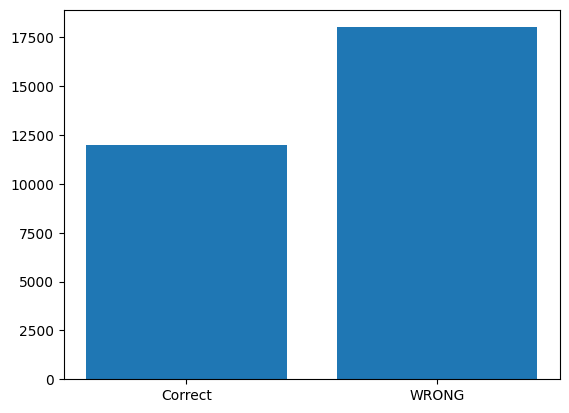

In [32]:
import matplotlib.pyplot as plt
plt.bar(["Correct", "WRONG"], c)

<Axes: >

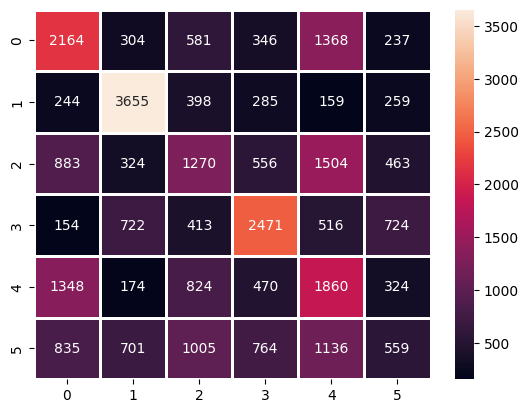

In [33]:
import seaborn as sns
sns.heatmap(a, linewidths=1, annot=True, fmt='g')

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
w2vmodel = Word2Vec.load("../input/modelll/embedding.model")
w2vmodel.wv.index_to_key